In [216]:
from numpy.random import randint
from tqdm import tnrange, tqdm_notebook
from math import exp
from itertools import product
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
from statsmodels.tsa.stattools import acf
from pandas.core.frame import DataFrame
from math import floor
import numpy as np
from pandas import read_csv
from math import pi,log,sqrt

def periodic_index(i, L):
    """ Returns the correct index for a periodic system. 

     Args:
        i (int): Desired index.

        L (int): Dimension of boundary. 
    
    Returns:
        (int): Remapped index.
    """

    return i%L


def get_random_number_between_0_and_1():
    """ Returns a random number between 0 and 1.
    
    Args:
        None
        
    Returns:
        (float): random float between 0 and 1.
    """

    return np.random.random()



class MonteCarloSimulation:
    """ Object representing a Monte Carlo simulation of the 2D Ising model."""
    
    def __init__(self, L, T):
        """ Constructor for the MonteCarloSim class.
         
         Args:
            L (int): Size of lattice.
                The lattice is made up of L^2 total spins.
                
            T (float): Temperature in units of J/k_B. 
                Note: J is the first coefficient in the expression for 
                the energy, not Joules. 
        
        """
        
        self.L = L 
        self.T = T
        self.sigma = np.random.choice([-1, 1], size=(L, L)) # 产生L^2个随机数，每个数是1或-1 σ_(i,j)
        self.data = {}
        
    def E_dimensionless(self):
        """ Calculates the energy of the lattice in the current configuration
        in units of J. No external magnetic field is present (i.e. H=0).
        
        Args: 
             None
    
        Returns: 
            total_energy (float): The energy of the lattice normalized by J.
                Note: J is the first coefficient in the expression for 
                the energy, not Joules.
        
        """

        # TODO: Write a code that calculates the total energy. (Equation 7)
        # (use periodic_index(...) to handle border spins.)
        fake_total_energy = 0
        # YOUR CODE HERE
        for i in range(self.L):
            for j in range(self.L):
                fake_total_energy += self.sigma[i,j]*self.sigma[i,periodic_index(j+1,self.L)]+self.sigma[i,j]*self.sigma[periodic_index(i+1,self.L),j]
        total_energy = -fake_total_energy 
        return total_energy

    def magnetization(self):
        """ Returns the total magentization for the current lattice 
        configuration. Note, this is the absolute value of M.
        
        Args: 
            None
    
        Returns:
            M (int) the total magnetization of the current lattice configuration.
        """
        # TODO: Write code that calcualtes the total magnetization.
        M = abs(np.sum(self.sigma))
        
        return M 
    
    def neighbor_energy(self, i, j, flip):
        """ Calculates the energy of a cluster of adjacent spins centered 
        around i, j.
        
        Args: 
            i (int): The row of the center site.
            
            j (int): The column of the center site.
            
            flip (bool): Whether or not to test a flipped spin on the center.
    
        Returns:
            NE (float): The cluster energy.
            
            """
        if flip:
            center = -self.sigma[i,j]
        else:
            center = self.sigma[i,j]
        
        down = self.sigma[(i+1)%self.L, j] # spin on the atom below the center
        up = self.sigma[(i-1)%self.L, j] # spin on the atom above the center
        right = self.sigma[i, (j+1)%self.L] # spin on the atom right of the center
        left = self.sigma[i, (j-1)%self.L] # spin on the atom left of the center
        
        # TODO: calculate the cluster energy
        NE = -(center*down + center*up + center*right + center*left)
        
        return NE
   
    def calculate_dE(self, i, j):
        """ Returns the energy change associated with flipping the spin
            at i, j.
                
        Args: 
            i (int): The row of the center site.
            
            j (int): The column of the center site.
    
        Returns:
            dE (float): The energy change associated with flipping the spin at i, j.
            """
        # TODO: Calculate the energy difference when atom (i,j) is flipped and not flipped.
        # (use self.neighbor_energy(...) to get the cluster energy)
        dE = self.neighbor_energy(i,j,flip=True) - self.neighbor_energy(i,j,flip=False)
        return dE

    def perturb(self):
        """ Attempts a spin flip at a random spin on the lattice. If the energy
        change is negative the flip is accepted. If the energy change is positive,
        the spin flip is rejected unless exp(-dE/T) > a random float between 0 and
        1. 
            """
        # Pick a random site.
        i = randint(0, self.L)
        j = randint(0, self.L)
        
        # TODO: Calculate change in energy if site was flipped.
        dE = self.calculate_dE(i,j)
        
        # TODO: Define the probability of success.
        P_of_success = exp(-dE/self.T)
        
        # TODO: Write code that accepts flipped moment under success conditions.
        # (use get_random_number_between_0_and_1() )
        # YOUR CODE HERE
        if P_of_success > get_random_number_between_0_and_1():
            self.sigma[i,j] = -self.sigma[i,j]
        else:
            self.sigma[i,j] = self.sigma[i,j]
    
    def run_simulation(self, N):
        """ Runs the simulation for N Monte Carlo steps. 
                
        Args: 
            N (int): Number of Monte Carlo steps (1 MC step = L^2 spin flip attempts)
            
    
        Returns:
            data (dict): The results of the simulation (T, L, 
            and arrays of the energy, and magnetization for each MC step.)
            
            """
        energies = [[] for i in range(N)]
        magnetizations = [[] for i in range(N)]
        X = [[] for i in range(N)]
        for i in range(0, N):
            for j in range(self.L**2):
                self.perturb()
            energies[i] = self.E_dimensionless()
            magnetizations[i] = self.magnetization()
            X[i] = self.magnetization()/self.L**2
        data = {"T": self.T, "L": self.L, "E": energies,  "M": magnetizations, "M_per_site":X}
        self.data = data
        self.X = X
        return data
    
    def plot(self, title):
        """ Plots the current state of the system.
                
        Args: 
            title (str): Title for the plot.
            
            """
        plt.figure(figsize=[10, 10])
        fig = plt.imshow(self.sigma)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.title(title, fontsize=18)
        plt.show()
        
    def to_file(self):
        """ Writes the simulation data to a csv file"""
        
        df = pd.DataFrame.from_dict(self.data)
        filename = "MC_RUN_SUMMARY_L_{}_T_{}.csv".format(self.L, self.T)
        df.to_csv(filename)

In [ ]:
# define an auto-correlation function
def autocorrelation(X,cutoff=1000):
    series = pd.Series(X)
    G = acf(series,nlags=cutoff)
    total = 0
    zero = None
    for i,g in enumerate(G):
        if g < 0:
            zero = i
            break
        total += g
        if zero is len(G)-1:
            print("never crossed 0!")
    return G[0:zero], total
    
#calculate magnetic susceptibility per site
def MS(M, L, T):
    """
    Returns the magnetic susceptibility
    M = magnetization vs. time
    L = size
    T = temperature
    """
    return np.std(M)**2/(T*L**2)

#calculate the heat capacity
def heat_capacity(E, L, T):
    """
    Calculates the heat capacity
    E = energy vs. time
    T = temperature
    L = size
    """
    return np.std(E)**2/((T**2)*(L**2))

In [20]:
#run MC simulation in temerperature range [0.8*Tc,1.6*Tc], 0.1 K as interval 
import numpy as np
tem = [round(i,2) for i in np.arange(1.8, 3.7, 0.1)]
error = []
MagS = []

for t in tem:
    MC = MonteCarloSimulation(32, t)
    MC.run_simulation(10000)
    MC.to_file()

#MC simulation for L = 4
for t in tem:
    MC = MonteCarloSimulation(4, t)
    MC.run_simulation(10000)
    MC.to_file()

#MC simulation for L = 8
for t in tem:
    MC = MonteCarloSimulation(8, t)
    MC.run_simulation(10000)
    MC.to_file()

#MC simulation for L = 16
for t in tem:
    MC = MonteCarloSimulation(16, t)
    MC.run_simulation(10000)
    MC.to_file()

In [3]:
from pandas import read_csv
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
tem = [round(i,2) for i in np.arange(1.8, 3.7, 0.1)]

In [18]:
#bookstrip function to calculate the uncertainty of erergy per site E_per_site
def bs_energy(data, L, R=10000):
    l = len(data)
    UC = []     #create a list to store the mean of E_per_site in every resampling step
    E_per_site = data/L**2
    
    for i in range(R):
        sampled_data = np.random.choice(E_per_site, size = floor(l/(2*autocorrelation(E_per_site)[1])),replace=True)
        uc = np.mean(sampled_data)
        UC.append(uc)
    return np.std(UC)

In [30]:
#calculate E and its error bar when L=32
from pandas import read_csv
from ipywidgets import interact
import ipywidgets as widgets
error_E_32 = []
E_32 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()

    er = bs_energy(x, 32)
    error_E_32.append(er)
    
    e = np.mean(x/32**2)
    E_32.append(e)

#calculate E and its error bar when L=16
error_E_16 = []
E_16 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(16, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()

    er = bs_energy(x, 16)
    error_E_16.append(er)
    
    e = np.mean(x/16**2)
    E_16.append(e)

#calculate E and its error bar when L=8
error_E_8 = []
E_8 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(8, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()

    er = bs_energy(x, 8)
    error_E_8.append(er)
    
    e = np.mean(x/8**2)
    E_8.append(e)

#calculate E and its error bar when L=4
error_E_4 = []
E_4 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(4, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()

    er = bs_energy(x, 4)
    error_E_4.append(er)
    
    e = np.mean(x/4**2)
    E_4.append(e)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:06:30<00:00, 210.90s/it]


In [34]:
import os
os.getcwd()

e = [E_4, error_E_4, E_8, error_E_8, E_16, error_E_16, E_32, error_E_32]
name = ['4','4e','8','8e','16','16e','32','32e']
e_t = list(map(list, zip(*e)))
df = pd.DataFrame(columns = name, index = tem, data = e_t)
df.to_csv('E.csv')
df.head()

,4,4e,8,8e,16,16e,32,32e
1.8,-1.857286,0.007917,-1.856295,0.004586,-1.859353,0.002249,-1.858950,0.001082
1.9,-1.793714,0.011575,-1.806545,0.005379,-1.806969,0.002823,-1.808714,0.001353
2.0,-1.747536,0.012074,-1.751643,0.007250,-1.743402,0.003706,-1.746300,0.002014
2.1,-1.677214,0.013546,-1.672286,0.009907,-1.665109,0.006037,-1.656652,0.003087
2.2,-1.604750,0.015022,-1.573705,0.012556,-1.537453,0.008500,-1.538967,0.007092


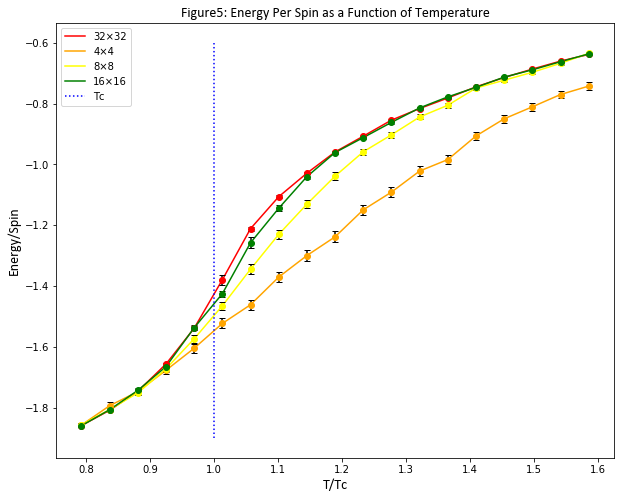

In [420]:
#plot for L=4,8,16,32 value and uncertainty of energy per site
normalized_tem = [t/2.27 for t in tem]
_ = plt.figure(figsize=(10,8))
_ = plt.plot(normalized_tem, E_32, color = 'red')
_ = plt.plot(normalized_tem, E_4, color = 'orange')
_ = plt.plot(normalized_tem, E_8, color = 'yellow')
_ = plt.plot(normalized_tem, E_16, color = 'green')
_ = plt.errorbar(x = np.linspace(1.0, 1.0, 200), y = np.linspace(-1.9, -0.6, 200), color = 'blue',ls = ':')
_ = plt.errorbar(x = normalized_tem, y = E_32, yerr = error_E_32, fmt='o', color = 'red', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = E_4, yerr = error_E_4, fmt='o', color = 'orange', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = E_8, yerr = error_E_8, fmt='o', color = 'yellow', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = E_16, yerr = error_E_16, fmt='o', color = 'green', ecolor = 'black', capsize = 3)
_ = plt.xlabel('T/Tc', fontsize = 14, fontname = 'Calibri')
_ = plt.ylabel('Energy/Spin', fontsize = 14, fontname = 'Calibri')
_ = plt.title('Figure5: Energy Per Spin as a Function of Temperature',fontsize = 14, fontname = 'Calibri')
_ = plt.legend(["32×32","4×4","8×8","16×16","Tc"])
plt.show()

In [19]:
#bookstrip function to calculate the uncertainty of magnetization per site M_per_site
def bs_mag(data, R=10000):
    l = len(data)
    UC = []     #create a list to store the mean of M_per_site in every resampling step
   
    for i in range(R):
        sampled_data = np.random.choice(data, size = floor(l/(2*autocorrelation(data)[1])),replace=True)
        uc = np.mean(sampled_data)
        UC.append(uc)
    return np.std(UC)

In [32]:
from pandas import read_csv
from ipywidgets import interact
import ipywidgets as widgets

#calculate magnetization per site and its error bar when L=32
error_Mag_32 = []
Mag_32 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, t))
    df = df.drop(index=range(0,3000))
    x= df['M_per_site'].to_numpy()

    er = bs_mag(x)
    error_Mag_32.append(er)
    
    e = np.mean(x)
    Mag_32.append(e)
    
#calculate magnetization per site and its error bar when L=16
error_Mag_16 = []
Mag_16 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(16, t))
    df = df.drop(index=range(0,3000))
    x = df['M_per_site'].to_numpy()

    er = bs_mag(x)
    error_Mag_16.append(er)
    
    e = np.mean(x)
    Mag_16.append(e)
    
#calculate magnetization per site and its error bar when L=8
error_Mag_8 = []
Mag_8 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(8, t))
    df = df.drop(index=range(0,3000))
    x = df['M_per_site'].to_numpy()

    er = bs_mag(x)
    error_Mag_8.append(er)
    
    e = np.mean(x)
    Mag_8.append(e)

#calculate magnetization per site and its error bar when L=4
error_Mag_4 = []
Mag_4 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(4, t))
    df = df.drop(index=range(0,3000))
    x = df['M_per_site'].to_numpy()

    er = bs_mag(x)
    error_Mag_4.append(er)
    
    e = np.mean(x)
    Mag_4.append(e)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:06:53<00:00, 211.52s/it]


In [45]:
import os
os.getcwd()

mag = [Mag_4, error_Mag_4, Mag_8, error_Mag_8, Mag_16, error_Mag_16, Mag_32, error_Mag_32]
name = ['4','4e','8','8e','16','16e','32','32e']
mag_t = list(map(list, zip(*mag)))
df = pd.DataFrame(columns = name, index = tem, data = mag_t)
df.to_csv('Mag.csv')
df.head()

,4,4e,8,8e,16,16e,32,32e
1.8,0.955411,0.002980,0.954554,0.002249,0.956765,0.000979,0.956583,0.000488
1.9,0.930589,0.004956,0.937179,0.002470,0.937196,0.001496,0.937664,0.000693
2.0,0.913786,0.005388,0.915482,0.003819,0.909855,0.003130,0.910539,0.002166
2.1,0.888321,0.006041,0.878281,0.006608,0.871512,0.005053,0.864424,0.002880
2.2,0.859268,0.006742,0.827321,0.009128,0.788718,0.010352,0.779742,0.010790


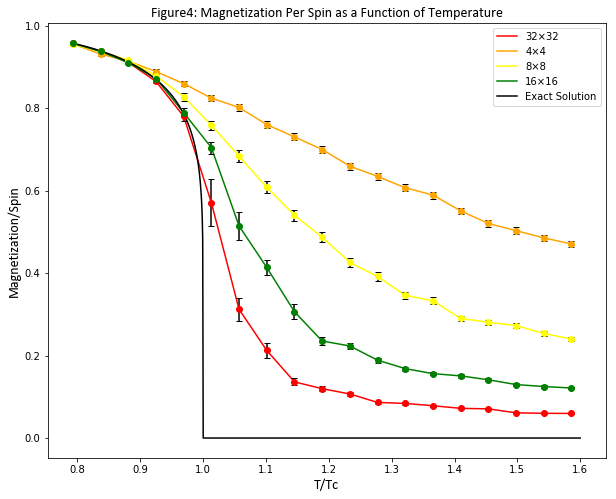

In [416]:
#plot for L=4,8,16,32 value and uncertainty of magnetization per site
normalized_tem = [t/2.27 for t in tem]
x_exact = np.linspace(0.8, 1.6, 1000)
m_exact = []
for x in x_exact:
    if x < 1:
        m = (1-np.sinh(np.log(1+np.sqrt(2))/x)**(-4))**(1/8)
        m_exact.append(m)
    else:
        m_exact.append(0)
_ = plt.figure(figsize=(10,8))
_ = plt.plot(normalized_tem, Mag_32, color = 'red')
_ = plt.plot(normalized_tem, Mag_4, color = 'orange')
_ = plt.plot(normalized_tem, Mag_8, color = 'yellow')
_ = plt.plot(normalized_tem, Mag_16, color = 'green')
_ = plt.plot(x_exact, m_exact, color = 'black', linewidth = 1.5)
#_ = plt.errorbar(x = np.linspace(1.0, 1.0, 200), y = np.linspace(0, 1, 200), color = 'blue',ls = ':')
_ = plt.errorbar(x = normalized_tem, y = Mag_32, yerr = error_Mag_32, fmt='o', color = 'red', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = Mag_4, yerr = error_Mag_4, fmt='o', color = 'orange', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = Mag_8, yerr = error_Mag_8, fmt='o', color = 'yellow', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = Mag_16, yerr = error_Mag_16, fmt='o', color = 'green', ecolor = 'black', capsize = 3)
_ = plt.xlabel('T/Tc',fontsize = 14, fontname = 'Calibri')
_ = plt.ylabel('Magnetization/Spin', fontsize = 14, fontname = 'Calibri')
_ = plt.title('Figure4: Magnetization Per Spin as a Function of Temperature',fontsize = 14, fontname = 'Calibri')
_ = plt.legend(["32×32","4×4","8×8","16×16","Exact Solution"])
plt.show()

In [203]:
#calculate MagS and its error bar when L =32
from pandas import read_csv
from ipywidgets import interact
import ipywidgets as widgets
from astropy.stats import bootstrap
error_32 = []
MagS_32 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, t))
    df = df.drop(index=range(0,3000))
    x = df['M'].to_numpy()
    y = df['M_per_site'].to_numpy()
    l = len(x)
    
    s_mags = bootstrap(x, bootnum= 10000, samples=floor(l/(2*autocorrelation(y)[1])),bootfunc=np.std)**2/(t*32**2)
    uc = np.std(s_mags)
    error_32.append(uc)

    mags = MS(x, 32, t)
    MagS_32.append(mags)

#calculate MagS and its error bar when L = 4
from pandas import read_csv
error_4 = []
MagS_4 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(4, t))
    df = df.drop(index=range(0,3000))
    x = df['M'].to_numpy()
    y = df['M_per_site'].to_numpy()
    l = len(x)
    
    s_mags = bootstrap(x, bootnum= 10000, samples=floor(l/(2*autocorrelation(y)[1])),bootfunc=np.std)**2/(t*4**2)
    uc = np.std(s_mags)
    error_4.append(uc)

    mags = MS(x, 4, t)
    MagS_4.append(mags)

#calculate MagS and its error bar when L = 8
from pandas import read_csv
error_8 = []
MagS_8 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(8, t))
    df = df.drop(index=range(0,3000))
    x = df['M'].to_numpy()
    y = df['M_per_site'].to_numpy()
    l = len(x)
    
    s_mags = bootstrap(x, bootnum= 10000, samples=floor(l/(2*autocorrelation(y)[1])),bootfunc=np.std)**2/(t*8**2)
    uc = np.std(s_mags)
    error_8.append(uc)

    mags = MS(x, 8, t)
    MagS_8.append(mags)

#calculate MagS and its error bar when L = 16
from pandas import read_csv
error_16 = []
MagS_16 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(16, t))
    df = df.drop(index=range(0,3000))
    x = df['M'].to_numpy()
    y = df['M_per_site'].to_numpy()
    l = len(x)
    
    s_mags = bootstrap(x, bootnum= 10000, samples=floor(l/(2*autocorrelation(y)[1])),bootfunc=np.std)**2/(t*16**2)
    uc = np.std(s_mags)
    error_16.append(uc)

    mags = MS(x, 16, t)
    MagS_16.append(mags)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.13it/s]


In [204]:
import os
os.getcwd()

MagS = [MagS_4, error_4, MagS_8, error_8, MagS_16, error_16, MagS_32, error_32]
name = ['4','4e','8','8e','16','16e','32','32e']
MagS_t = list(map(list, zip(*MagS)))
df = pd.DataFrame(columns = name, index = tem, data = MagS_t)
df.to_csv('MagS.csv')
df.head()

,4,4e,8,8e,16,16e,32,32e
1.8,0.110641,0.013790,0.151257,0.027778,0.117889,0.010694,0.119916,0.008242
1.9,0.194034,0.023977,0.190899,0.022412,0.203131,0.026214,0.197727,0.011946
2.0,0.222608,0.023599,0.283148,0.041534,0.405946,0.091315,0.481163,0.105590
2.1,0.265451,0.024015,0.564651,0.091847,0.738159,0.125295,0.955470,0.111774
2.2,0.330554,0.024914,0.882506,0.125800,1.998985,0.359317,3.255453,0.701611


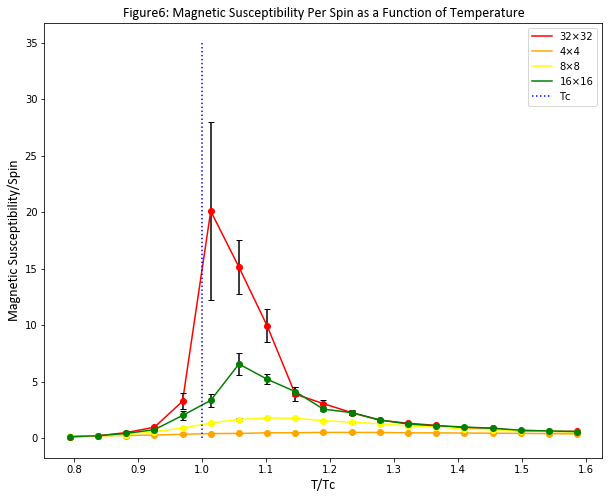

In [419]:
#plot for L=4,8,16,32 value and uncertainty of MS
normalized_tem = [t/2.27 for t in tem]
_ = plt.figure(figsize=(10,8))
_ = plt.plot(normalized_tem, MagS_32, color = 'red')
_ = plt.plot(normalized_tem, MagS_4, color = 'orange')
_ = plt.plot(normalized_tem, MagS_8, color = 'yellow')
_ = plt.plot(normalized_tem, MagS_16, color = 'green')
_ = plt.errorbar(x = np.linspace(1.0, 1.0, 1000), y = np.linspace(0, 35, 1000), color = 'blue',ls = ':')
_ = plt.errorbar(x = normalized_tem, y = MagS_32, yerr = error_32, fmt='o', color = 'red', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = MagS_4, yerr = error_4, fmt='o', color = 'orange', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = MagS_8, yerr = error_8, fmt='o', color = 'yellow', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = MagS_16, yerr = error_16, fmt='o', color = 'green', ecolor = 'black', capsize = 3)
_ = plt.xlabel('T/Tc', fontsize = 14, fontname = 'Calibri')
_ = plt.ylabel('Magnetic Susceptibility/Spin', fontsize = 14, fontname = 'Calibri')
_ = plt.title('Figure6: Magnetic Susceptibility Per Spin as a Function of Temperature',fontsize = 14, fontname = 'Calibri')
_ = plt.legend(["32×32","4×4","8×8","16×16","Tc"])
plt.show()

In [4]:
#bootstrap method to calculate uncertainty of heat capacity
def bs_hc(data, L, t, R=10000):
    HC = []
    l = len(data)
    
    for i in range(R):
        sampled_data = np.random.choice(data, size = floor(l/(2*autocorrelation(data)[1])),replace=True)
        hc = heat_capacity(sampled_data, L, t)
        HC.append(hc)
    return np.std(HC)

In [5]:
#calculate HC and its error bar when L =32
from pandas import read_csv
error32 = []
HC32 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()
    
    er = bs_hc(x, 32, t)
    error32.append(er)

    hc = heat_capacity(x, 32, t)
    HC32.append(hc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:19:56<00:00, 251.14s/it]


In [6]:
#calculate HC and its error bar when L =16
from pandas import read_csv
error16 = []
HC16 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(16, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()
    
    er = bs_hc(x, 16, t)
    error16.append(er)

    hc = heat_capacity(x, 16, t)
    HC16.append(hc)

#calculate HC and its error bar when L = 8
from pandas import read_csv
error8 = []
HC8 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(8, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()
    
    er = bs_hc(x, 8, t)
    error8.append(er)

    hc = heat_capacity(x, 8, t)
    HC8.append(hc)

#calculate HC and its error bar when L = 4
from pandas import read_csv
error4 = []
HC4 = []

for t in tqdm(tem):
    df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(4, t))
    df = df.drop(index=range(0,3000))
    x = df['E'].to_numpy()
    
    er = bs_hc(x, 4, t)
    error4.append(er)

    hc = heat_capacity(x, 4, t)
    HC4.append(hc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [1:33:12<00:00, 217.82s/it]


In [92]:
import os
os.getcwd()

hc = [HC4, error4, HC8, error8, HC16, error16, HC32, error32]
name = ['4','4e','8','8e','16','16e','32','32e']
hc_t = list(map(list, zip(*hc)))
df = pd.DataFrame(columns = name, index = tem, data = hc_t)
df.to_csv('HC.csv')
df.head()

,4,4e,8,8e,16,16e,32,32e
1.8,0.445099,0.031009,0.476411,0.030124,0.437957,0.020764,0.447439,0.018730
1.9,0.609576,0.042631,0.568198,0.030749,0.561894,0.026571,0.563846,0.023866
2.0,0.639369,0.035837,0.667832,0.038773,0.725254,0.037630,0.699320,0.036959
2.1,0.702386,0.034635,0.876168,0.060988,0.926103,0.067080,0.998984,0.068853
2.2,0.783591,0.035517,1.015437,0.063152,1.261311,0.096470,1.447167,0.170879


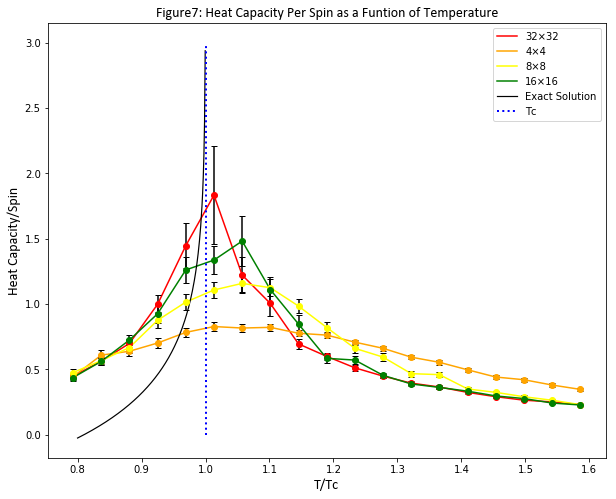

In [422]:
#plot for L=4,8,16,32 value and uncertainty of heat capacity
normalized_tem = [t/2.27 for t in tem]
x_exact = np.linspace(0.8, 0.9995, 200)
y_exact = []
for x in x_exact:
    y = (2/pi)*(log(1+sqrt(2)))**2*(-log(1-x)+log(1/log(1+sqrt(2)))-(1+pi/4))
    y_exact.append(y)
_ = plt.figure(figsize=(10,8))
_ = plt.plot(normalized_tem, HC32, color = 'red')
_ = plt.plot(normalized_tem, HC4, color = 'orange')
_ = plt.plot(normalized_tem, HC8, color = 'yellow')
_ = plt.plot(normalized_tem, HC16, color = 'green')
_ = plt.errorbar(x = np.linspace(1.0, 1.0, 200), y = np.linspace(0, 3, 200), color = 'blue',ls = ':', linewidth = 2)
_ = plt.plot(x_exact, y_exact, color = 'black',linewidth = 1.2)
_ = plt.errorbar(x = normalized_tem, y = HC32, yerr = error32, fmt='o', color = 'red', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = HC4, yerr = error4, fmt='o', color = 'orange', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = HC8, yerr = error8, fmt='o', color = 'yellow', ecolor = 'black', capsize = 3)
_ = plt.errorbar(x = normalized_tem, y = HC16, yerr = error16, fmt='o', color = 'green', ecolor = 'black', capsize = 3)
_ = plt.xlabel('T/Tc', fontsize = 14, fontname = 'Calibri')
_ = plt.ylabel('Heat Capacity/Spin', fontsize = 14, fontname = 'Calibri')
_ = plt.title('Figure7: Heat Capacity Per Spin as a Funtion of Temperature', fontsize = 14, fontname = 'Calibri')
_ = plt.legend(["32×32","4×4","8×8","16×16","Exact Solution","Tc"])
plt.show()














  0%|                                                                                                                                                                                     | 0/20 [00:00<?, ?it/s]

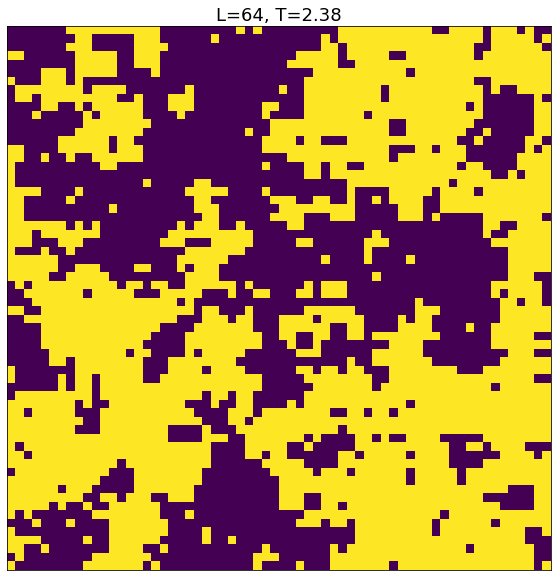














  5%|████████▌                                                                                                                                                                 | 1/20 [14:17<4:31:28, 857.27s/it]

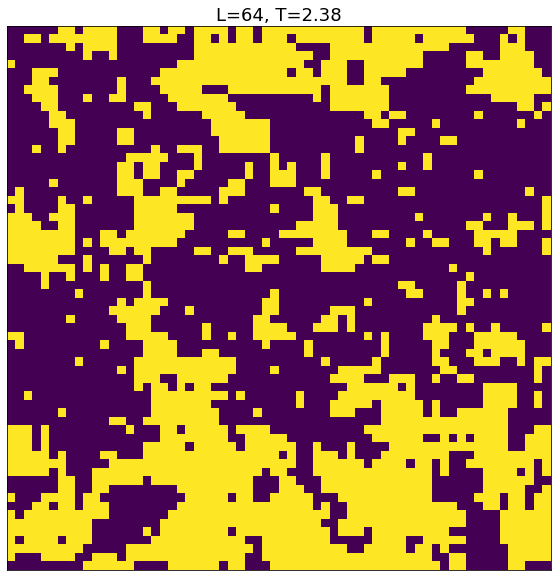














 10%|█████████████████                                                                                                                                                         | 2/20 [28:48<4:18:28, 861.58s/it]

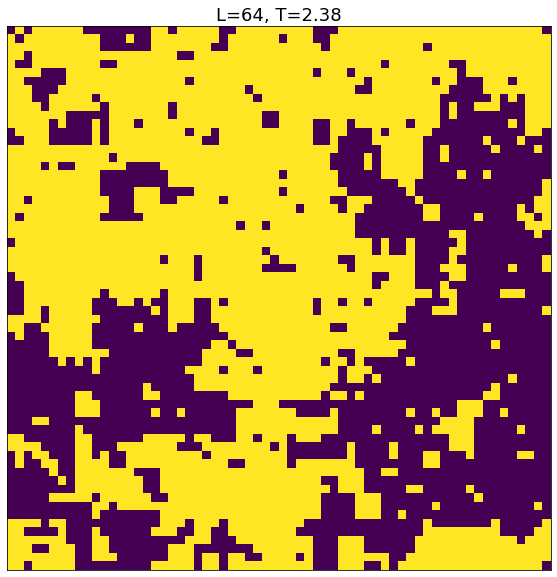














 15%|█████████████████████████▌                                                                                                                                                | 3/20 [42:10<3:59:02, 843.66s/it]

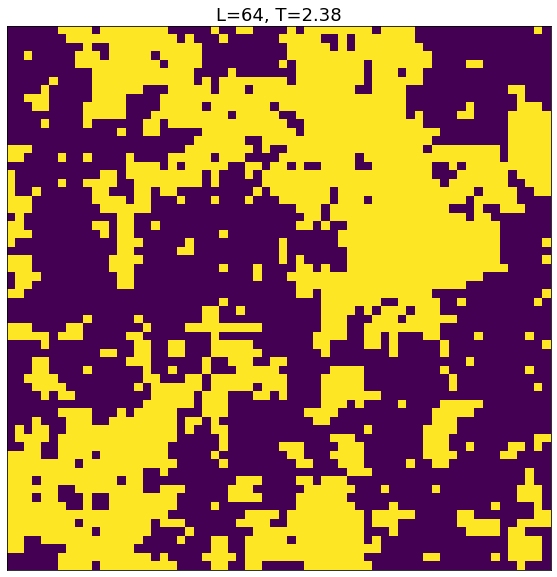














 20%|██████████████████████████████████                                                                                                                                        | 4/20 [56:00<3:43:51, 839.49s/it]

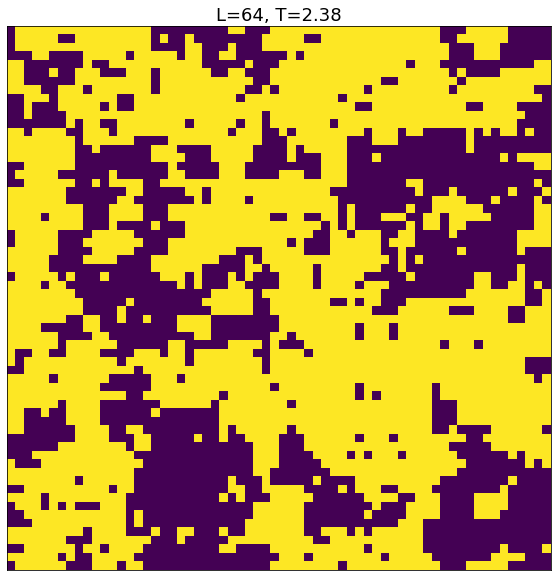














 25%|██████████████████████████████████████████                                                                                                                              | 5/20 [1:09:17<3:26:39, 826.66s/it]

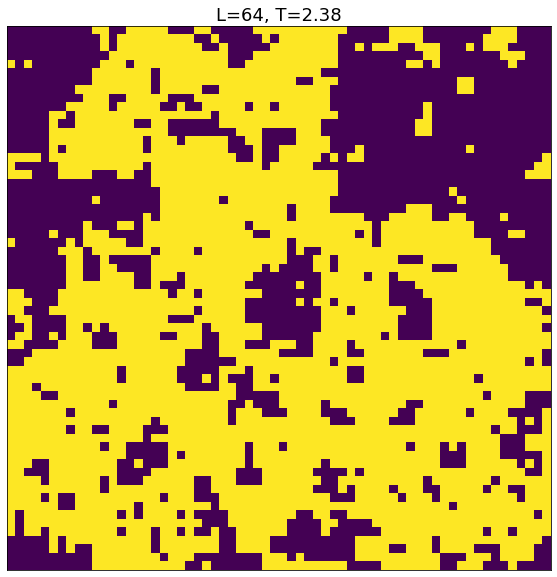














 30%|██████████████████████████████████████████████████▍                                                                                                                     | 6/20 [1:22:12<3:09:18, 811.32s/it]

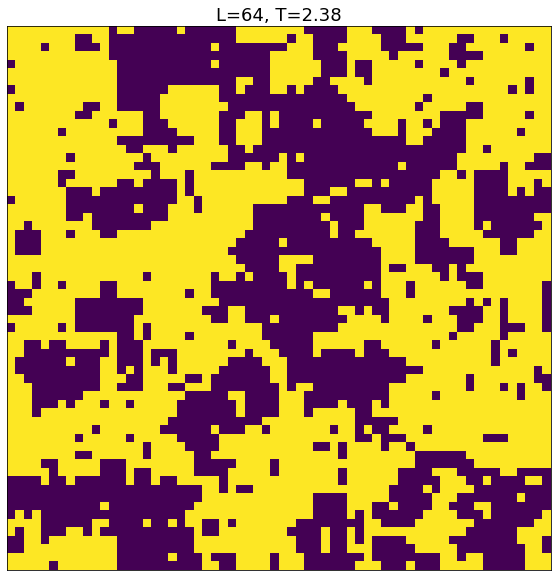














 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 7/20 [1:34:57<2:52:47, 797.47s/it]

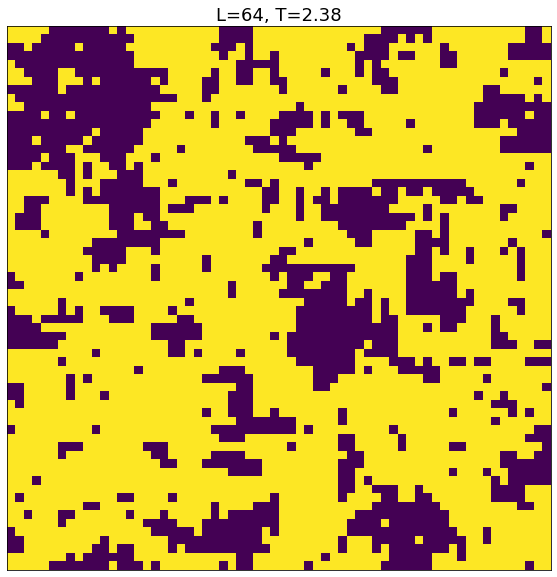














 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 8/20 [1:47:58<2:38:27, 792.29s/it]

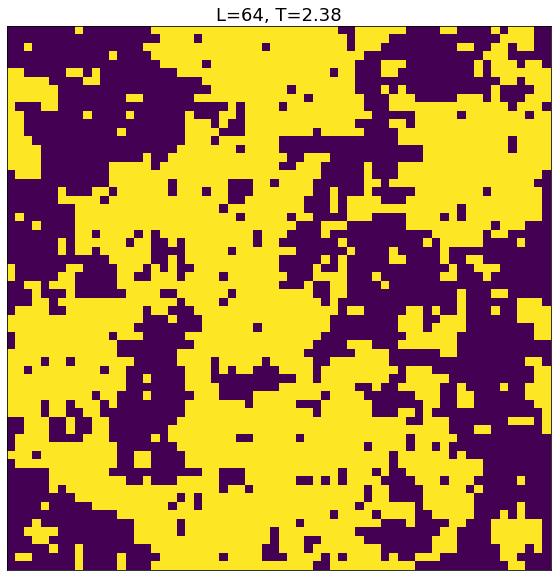














 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 9/20 [2:01:34<2:26:34, 799.54s/it]

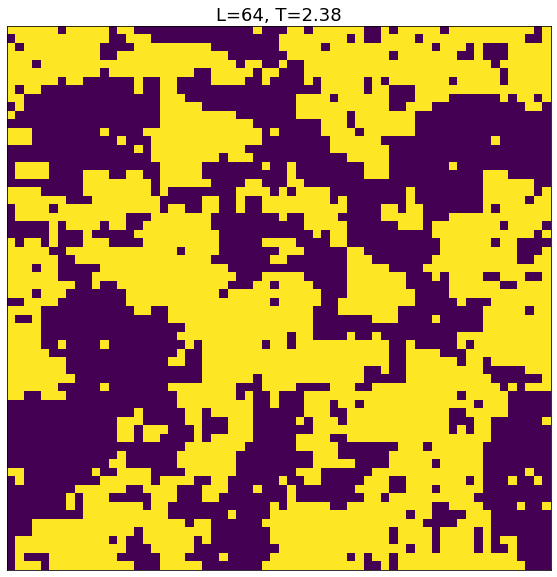














 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10/20 [2:14:26<2:11:51, 791.18s/it]

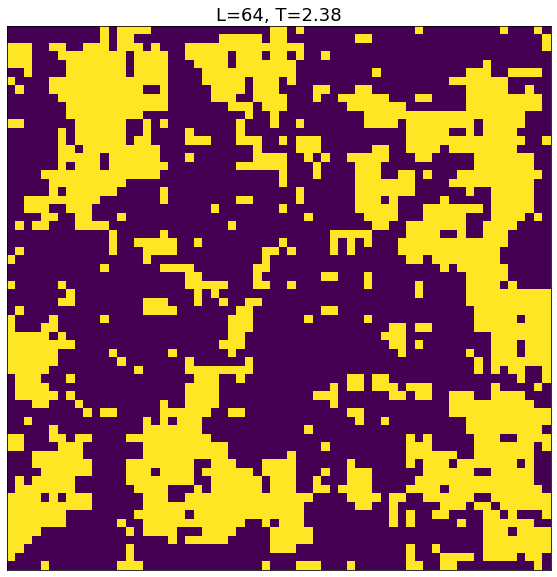














 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11/20 [2:27:15<1:57:41, 784.56s/it]

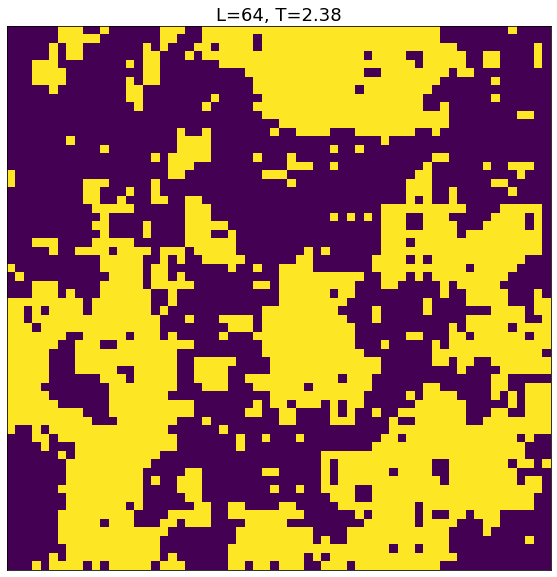














 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12/20 [2:40:06<1:44:03, 780.38s/it]

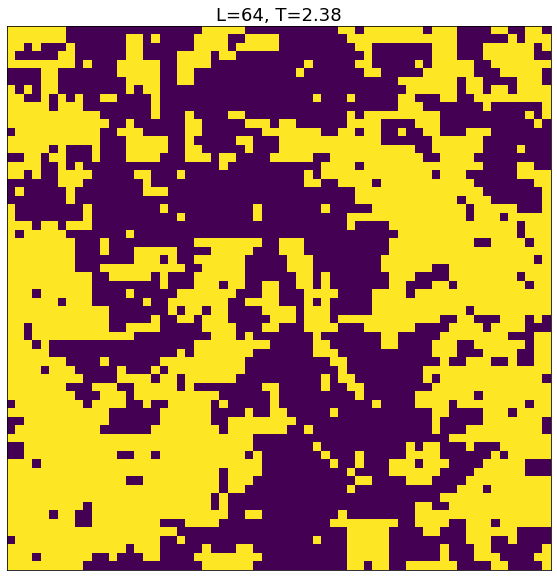














 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 13/20 [2:52:52<1:30:34, 776.31s/it]

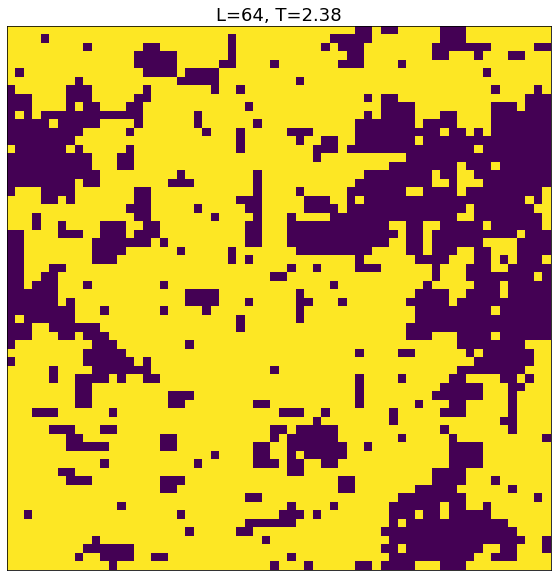














 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 14/20 [3:06:26<1:18:45, 787.56s/it]

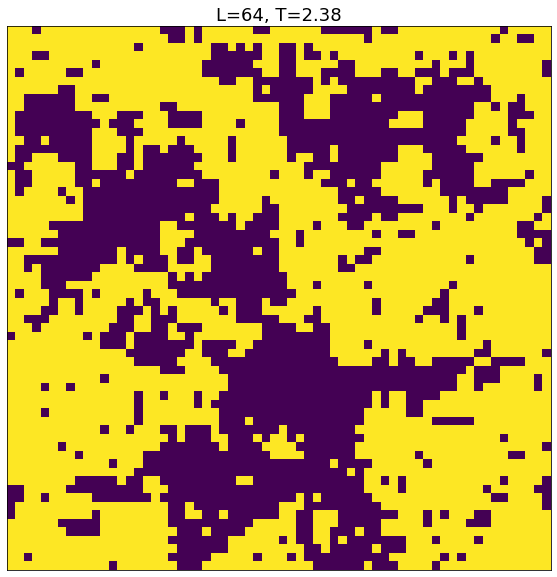














 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 15/20 [3:19:15<1:05:09, 781.96s/it]

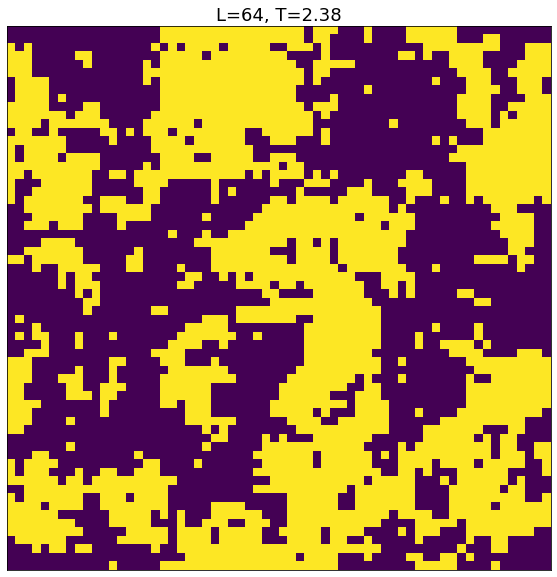














 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 16/20 [3:32:03<51:50, 777.74s/it]

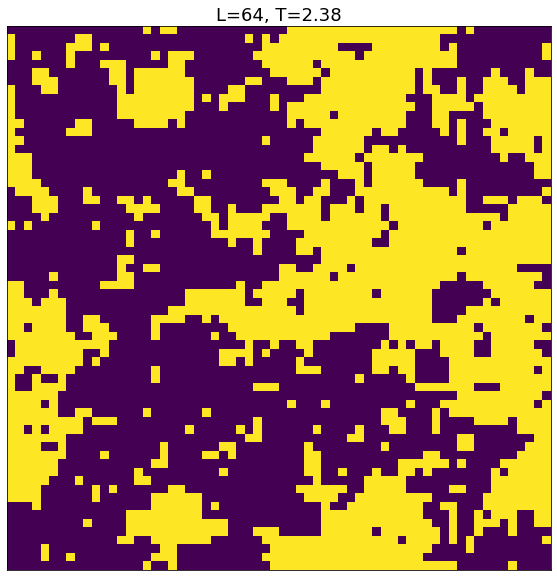














 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 17/20 [3:44:48<38:42, 774.09s/it]

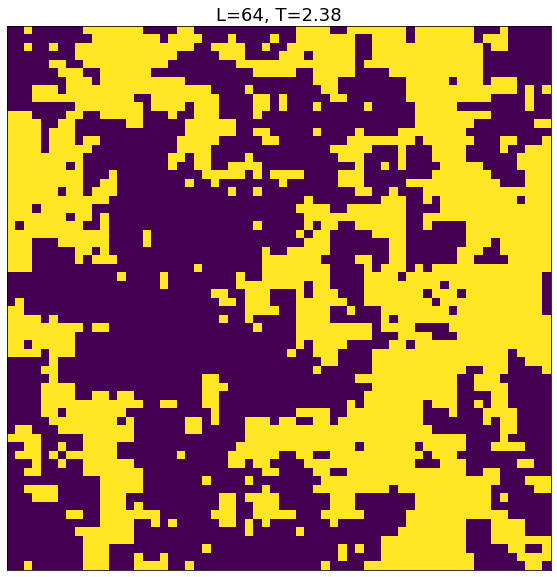














 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 18/20 [3:57:40<25:46, 773.35s/it]

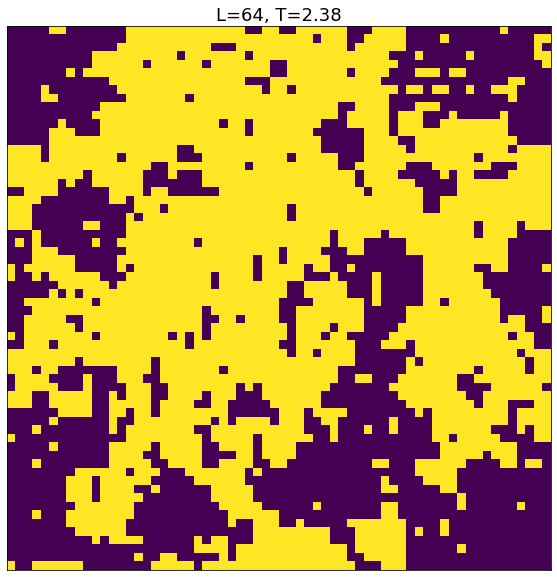














 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 19/20 [4:11:13<13:05, 785.36s/it]

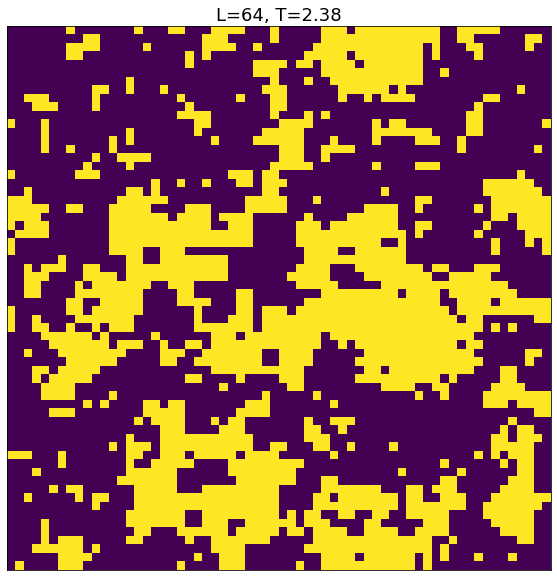














100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [4:24:06<00:00, 781.47s/it]

In [313]:
MC = MonteCarloSimulation(64,2.38)
for item in tqdm([5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]):
    MC.run_simulation(item)
    MC.plot('L=64, T=2.38')

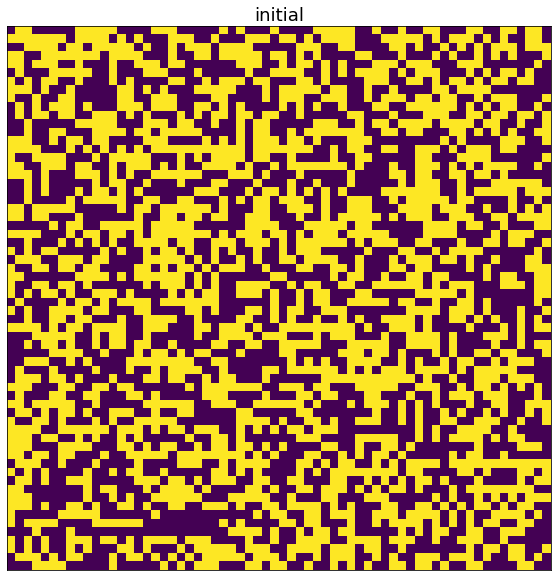

In [482]:
MC = MonteCarloSimulation(64, 2.38)
MC.plot('initial')

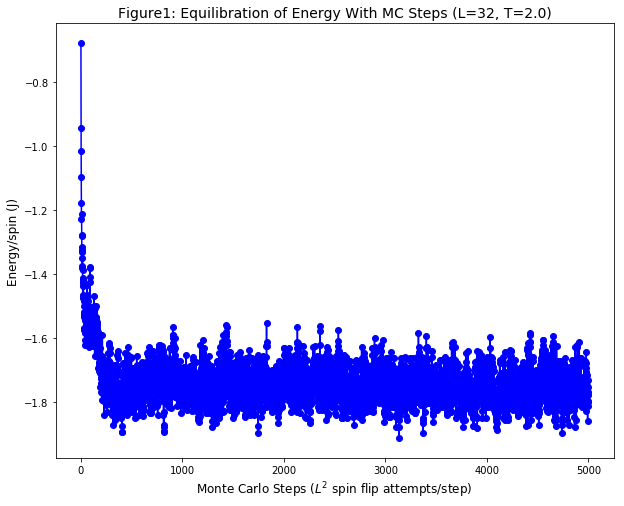

In [308]:
#plot the equilibration of the system, when L = 32
from IPython.display import Latex
df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, 2.0))
df = df.drop(range(5000,10000))
x = df['E'].to_numpy()/32**2
_ = plt.figure(figsize=(10,8))
_ = plt.xlabel('Monte Carlo Steps ($L^{2}$ spin flip attempts/step)',fontsize = 12)
_ = plt.ylabel('Energy/spin (J)',fontsize = 12)
_ = plt.title('Figure1: Equilibration of Energy With MC Steps (L=32, T=2.0)',fontsize = 14)
_ = plt.plot(x, 'b-o')

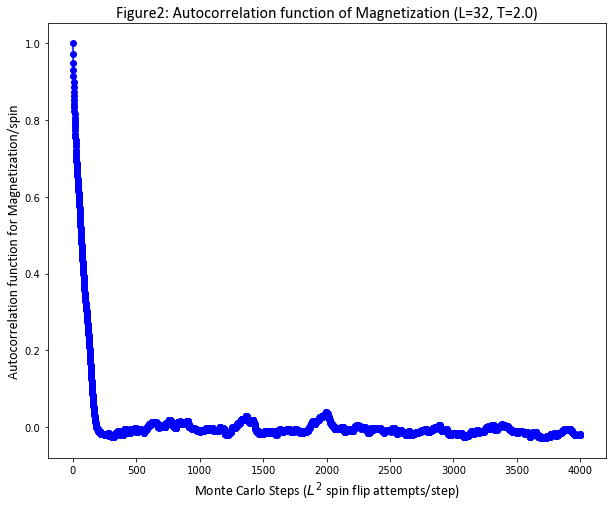

In [290]:
#plot the autocorrelation function for mag_per_spin, when L = 32
df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, 2.0))
x = df['M_per_site'].to_numpy()
series = pd.Series(x)
G = acf(series,nlags=4000)
_ = plt.figure(figsize=(10,8))
_ = plt.xlabel('Monte Carlo Steps ($L^{2}$ spin flip attempts/step)',fontsize = 14, fontname = 'Calibri')
_ = plt.ylabel('Autocorrelation function for Magnetization/spin',fontsize = 14, fontname = 'Calibri')
_ = plt.title('Figure2: Autocorrelation function of Magnetization (L=32, T=2.0)',fontsize = 16, fontname = 'Calibri')
_ = plt.plot(G, 'b-o')

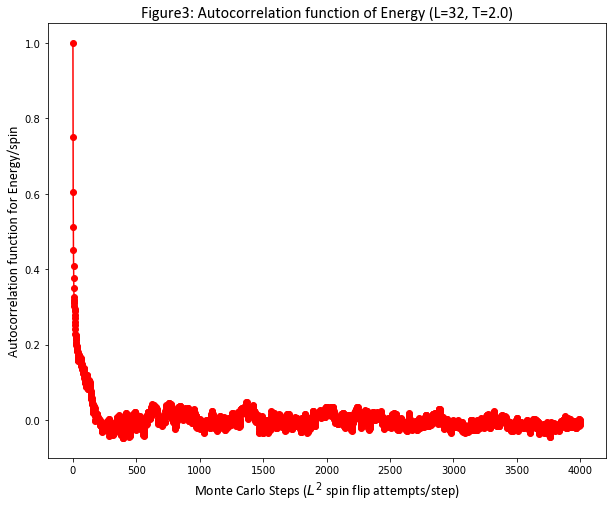

In [291]:
#plot the autocorrelation function for energy_per_spin, when L = 32
df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, 2.0))
x = df['E'].to_numpy()/32**2
series = pd.Series(x)
G = acf(series,nlags=4000)
_ = plt.figure(figsize=(10,8))
_ = plt.xlabel('Monte Carlo Steps ($L^{2}$ spin flip attempts/step)',fontsize = 14, fontname = 'Calibri')
_ = plt.ylabel('Autocorrelation function for Energy/spin',fontsize = 14, fontname = 'Calibri')
_ = plt.title('Figure3: Autocorrelation function of Energy (L=32, T=2.0)',fontsize = 16, fontname = 'Calibri')
_ = plt.plot(G, 'r-o')

In [467]:
#calculate n0 of Mag_per_site and energy when T=2.0, L=32
def ac_n0(X,cutoff=1000):
    series = pd.Series(X)
    G = acf(series,nlags=cutoff)
    total = 0
    zero = None
    for i,g in enumerate(G):
        if g < 0:
            zero = i
            break
        total += g
        if zero is len(G)-1:
            print("never crossed 0!")
    return zero
df = read_csv("MC_RUN_SUMMARY_L_{}_T_{}.csv".format(32, 2.0))
x = df['M_per_site'].to_numpy()
print(ac_n0(x))
y = df['E'].to_numpy()
print(ac_n0(y))

185
177


In [479]:
class Finite_size_effect:
    """ Object representing a Monte Carlo simulation of the 2D Ising model, to test the finite size effect"""
    
    def __init__(self, L, T):
        """ Constructor for the MonteCarloSim class.
         
         Args:
            L (int): Size of lattice.
                The lattice is made up of L^2 total spins.
                
            T (float): Temperature in units of J/k_B. 
                Note: J is the first coefficient in the expression for 
                the energy, not Joules. 
        
        """
        
        self.L = L 
        self.T = T
        self.sigma = np.random.choice([-1, 1], size=(L, L)) # 产生L^2个随机数，每个数是1或-1 σ_(i,j)
        self.data = {}
        
    def E_dimensionless(self):
        """ Calculates the energy of the lattice in the current configuration
        in units of J. No external magnetic field is present (i.e. H=0).
        
        Args: 
             None
    
        Returns: 
            total_energy (float): The energy of the lattice normalized by J.
                Note: J is the first coefficient in the expression for 
                the energy, not Joules.
        
        """

        # TODO: Write a code that calculates the total energy. (Equation 7)
        # (use periodic_index(...) to handle border spins.)
        fake_total_energy = 0
        # YOUR CODE HERE
        for i in range(self.L):
            for j in range(self.L):
                fake_total_energy += self.sigma[i,j]*self.sigma[i,periodic_index(j+1,self.L)]+self.sigma[i,j]*self.sigma[periodic_index(i+1,self.L),j]
        total_energy = -fake_total_energy 
        return total_energy

    def magnetization(self):
        """ Returns the total magentization for the current lattice 
        configuration. Note, this is the absolute value of M.
        
        Args: 
            None
    
        Returns:
            M (int) the total magnetization of the current lattice configuration.
        """
        # TODO: Write code that calcualtes the total magnetization.
        M = abs(np.sum(self.sigma))
        
        return M 
    
    def neighbor_energy(self, i, j, flip):
        """ Calculates the energy of a cluster of adjacent spins centered 
        around i, j.
        
        Args: 
            i (int): The row of the center site.
            
            j (int): The column of the center site.
            
            flip (bool): Whether or not to test a flipped spin on the center.
    
        Returns:
            NE (float): The cluster energy.
            
            """
        if flip:
            center = -self.sigma[i,j]
        else:
            center = self.sigma[i,j]
        
        down = self.sigma[(i+1)%self.L, j] # spin on the atom below the center
        up = self.sigma[(i-1)%self.L, j] # spin on the atom above the center
        right = self.sigma[i, (j+1)%self.L] # spin on the atom right of the center
        left = self.sigma[i, (j-1)%self.L] # spin on the atom left of the center
        
        # TODO: calculate the cluster energy
        NE = -(center*down + center*up + center*right + center*left)
        
        return NE
   
    def calculate_dE(self, i, j):
        """ Returns the energy change associated with flipping the spin
            at i, j.
                
        Args: 
            i (int): The row of the center site.
            
            j (int): The column of the center site.
    
        Returns:
            dE (float): The energy change associated with flipping the spin at i, j.
            """
        # TODO: Calculate the energy difference when atom (i,j) is flipped and not flipped.
        # (use self.neighbor_energy(...) to get the cluster energy)
        dE = self.neighbor_energy(i,j,flip=True) - self.neighbor_energy(i,j,flip=False)
        return dE

    def perturb(self):
        """ Attempts a spin flip at a random spin on the lattice. If the energy
        change is negative the flip is accepted. If the energy change is positive,
        the spin flip is rejected unless exp(-dE/T) > a random float between 0 and
        1. 
            """
        # Pick a random site.
        i = randint(0, self.L)
        j = randint(0, self.L)
        
        # TODO: Calculate change in energy if site was flipped.
        dE = self.calculate_dE(i,j)
        
        # TODO: Define the probability of success.
        P_of_success = exp(-dE/self.T)
        
        # TODO: Write code that accepts flipped moment under success conditions.
        # (use get_random_number_between_0_and_1() )
        # YOUR CODE HERE
        if P_of_success > get_random_number_between_0_and_1():
            self.sigma[i,j] = -self.sigma[i,j]
        else:
            self.sigma[i,j] = self.sigma[i,j]

    
    def run_simulation(self, N):
        """ Runs the simulation for N Monte Carlo steps. 
                
        Args: 
            N (int): Number of Monte Carlo steps (1 MC step = L^2 spin flip attempts)
            
    
        Returns:
            data (dict): The results of the simulation (T, L, 
            and arrays of the energy, and magnetization for each MC step.)
            
            """
        energies = [[] for i in range(N)]
        magnetizations = [[] for i in range(N)]
        X = [[] for i in range(N)]
        sigma = [[[] for j in range(self.L)] for i in range(N)]
        for i in range(0, N):
            for j in range(self.L**2):
                self.perturb()
            energies[i] = self.E_dimensionless()
            magnetizations[i] = self.magnetization()
            X[i] = self.magnetization()/self.L**2
            for k in range(self.L):
                sigma[i][k] = []
                for m in range(self.L):
                    sigma[i][k].append(self.sigma[k][m])
        data = {"T": self.T, "L": self.L, "E": energies,  "M": magnetizations, "M_per_site":X, "Sigma":sigma}
        self.data = data
        self.X = X
    
    def plot(self, title):
        """ Plots the current state of the system.
                
        Args: 
            title (str): Title for the plot.
            
            """
        plt.figure(figsize=[10, 10])
        fig = plt.imshow(self.sigma)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.title(title, fontsize=18)
        plt.show()
        
    def M1(self, deltai, deltaj, N, L):
        m1 = []
        for k in range(N):
            mean = []
            for i in range (L):
                for j in range(L):
                    mean.append(self.data["Sigma"][k][(i+deltai)%L][(j+deltaj)%L]*self.data["Sigma"][k][i][j])
            m1.append(np.mean(mean))
        return np.mean(m1)
    
    def M2(self,N, L):
        m2 = []
        for k in range(N):
            mean = []
            for i in range (L):
                for j in range(L):
                    mean.append(self.data["Sigma"][k][i][j])
            m2.append(np.mean(mean))
        return np.mean(m2)
    
    def M3(self, N, L):
        m3 = []
        for k in range(N):
            mean = []
            for i in range (L):
                for j in range(L):
                    mean.append(self.data["Sigma"][k][i][j]*self.data["Sigma"][k][i][j])
            m3.append(np.mean(mean))
        return np.mean(m3)
        
    def correlation_length(self, N, L):
        """Calculate the spin-spin correlation length for a certain Ising model L*L
            
        Args:
            N (int): number of Monte Carlo steps
            L (int): the lateral length of 2D Ising model
        
        Returns:
            correlation length (float)
            
        """
        
        SSC = []      #spin-spin correlation
        for i in tqdm(range(L)):
            for j in range(L):
                ssc = (self.M1(i, j, N, L) - self.M2(N, L)**2)/(self.M3(N, L) - self.M2(N, L)**2)
                if ssc > 0:
                    SSC.append(ssc)
                else:
                    break
        return (np.sum(SSC)*(2/3.1415926))**0.5
                    
    def to_file(self):
        """ Writes the simulation data to a csv file"""
        
        df = pd.DataFrame.from_dict(self.data)
        filename = "MC_Finite_size_effect_L_{}_T_{}.csv".format(self.L, self.T)
        df.to_csv(filename)

In [456]:
CL_4 = []
for t in tqdm(tem):
    fse = Finite_size_effect(4, t)
    fse.run_simulation(5000)
    cl = fse.correlation_length(5000, 4)
    CL_4.append(cl)
print(CL_4)















  0%|                                                                                                                                                                                     | 0/19 [00:00<?, ?it/s]













  5%|█████████                                                                                                                                                                    | 1/19 [00:25<07:35, 25.32s/it]













 11%|██████████████████▏                                                                                                                                                          | 2/19 [00:51<07:16, 25.70s/it]













 16%|███████████████████████████▎                                                                                                                                                 | 3/19 [01:15<06:39, 24.98s/it]













 21%|████████████████████████████████████▍                                                    

[3.0528142560389617, 3.012004385068538, 2.976030507184401, 2.870242366422277, 2.8279498938828365, 2.752047036132602, 2.6520247410993876, 2.545697370830641, 2.454409563719789, 2.382512169259414, 2.310822198300875, 2.1765394264075604, 2.1694637630901368, 2.0493164618901103, 2.015334398314474, 1.9585730373342187, 1.8808514560353233, 1.8250080264773278, 1.7629100879520778]


In [457]:
CL_8 = []
for t in tqdm(tem):
    fse = Finite_size_effect(8, t)
    fse.run_simulation(5000)
    cl = fse.correlation_length(5000, 8)
    CL_8.append(cl)
print(CL_8)















  0%|                                                                                                                                                                                     | 0/19 [00:00<?, ?it/s]













  5%|█████████                                                                                                                                                                   | 1/19 [02:46<49:55, 166.43s/it]













 11%|██████████████████                                                                                                                                                          | 2/19 [05:16<45:43, 161.39s/it]













 16%|███████████████████████████▏                                                                                                                                                | 3/19 [07:32<41:01, 153.85s/it]













 21%|████████████████████████████████████▏                                                    

[1.4635788331627007, 1.6803462341174835, 5.408839785219018, 1.5373257495715682, 5.3366498966146745, 4.988291217461993, 4.672102547698889, 4.233967706368883, 3.817381114826929, 3.4078378168219112, 3.146086496286521, 3.024538678417313, 2.6935076700356513, 2.5522517241967124, 2.262240162941973, 2.185633371797727, 2.084140186300393, 1.9447121576732442, 1.88147597289028]


In [458]:
CL_16 = []
for t in tqdm(tem):
    fse = Finite_size_effect(16, t)
    fse.run_simulation(5000)
    cl = fse.correlation_length(5000, 16)
    CL_16.append(cl)
print(CL_16)















  0%|                                                                                                                                                                                     | 0/19 [00:00<?, ?it/s]













  5%|████████▉                                                                                                                                                                | 1/19 [24:35<7:22:45, 1475.88s/it]













 11%|█████████████████▊                                                                                                                                                       | 2/19 [48:15<6:53:23, 1459.03s/it]













 16%|██████████████████████████▎                                                                                                                                            | 3/19 [1:14:14<6:37:02, 1488.88s/it]













 21%|███████████████████████████████████▏                                                     

[3.2900035162102563, 2.634663961954209, 2.419060677234524, 2.164000923005825, 3.3822615425996534, 8.508038717832186, 7.629274002718195, 6.008728874162788, 4.3122763431296125, 3.8582525449631797, 3.3030755573340644, 3.0091677982505303, 2.7978296573445736, 2.2667102148811478, 2.2521431239770067, 2.176562586827253, 1.9731829081175514, 1.9613606571770563, 1.787502035084953]


In [473]:
#make correction for the outlier in CL_8, when T=2.0
fse = Finite_size_effect(8, 2)
fse.run_simulation(5000)
cl = fse.correlation_length(5000, 8)
print(cl)

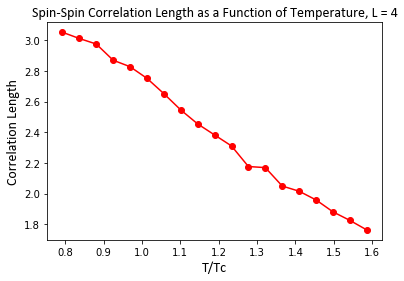

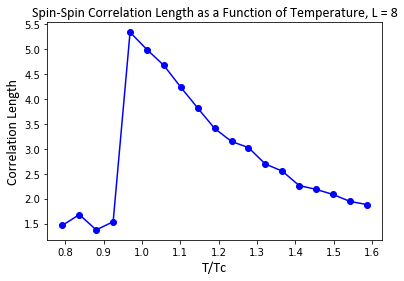

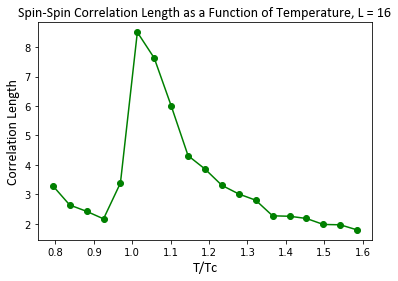

In [477]:
CL_8[2] = 1.3724881250488676 #correct the oulier when T=2.0
#plot the correlation length vs. temperature for L=4
plt.plot(normalized_tem, CL_4, color = 'Red', marker = 'o')
plt.xlabel('T/Tc',fontsize = 14, fontname = 'Calibri')
plt.ylabel('Correlation Length',fontsize = 14, fontname = 'Calibri')
plt.title("Spin-Spin Correlation Length as a Function of Temperature, L = 4", fontsize = 14, fontname = 'Calibri')
plt.show()

#plot the correlation length vs. temperature for L=8
plt.plot(normalized_tem, CL_8, color = 'Blue', marker = 'o')
plt.xlabel('T/Tc',fontsize = 14, fontname = 'Calibri')
plt.ylabel('Correlation Length',fontsize = 14, fontname = 'Calibri')
plt.title("Spin-Spin Correlation Length as a Function of Temperature, L = 8", fontsize = 14, fontname = 'Calibri')
plt.show()

#plot the correlation length vs. temperature for L=16
plt.plot(normalized_tem, CL_16, color = 'Green', marker = 'o')
plt.xlabel('T/Tc',fontsize = 14, fontname = 'Calibri')
plt.ylabel('Correlation Length',fontsize = 14, fontname = 'Calibri')
plt.title("Spin-Spin Correlation Length as a Function of Temperature, L = 16", fontsize = 14, fontname = 'Calibri')
plt.show()